In [39]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from PIL import ImageFile
import math
from sklearn.metrics import classification_report, confusion_matrix


In [12]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Ścieżki i parametry
DATASET_PATH = r"C:\Users\Weron\Desktop\AIML\dataset"
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 5


In [ ]:
# Generatory danych
train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=30,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)


In [24]:
# Wczytanie danych
important_classes = ['Bacterial_spot', 'Early_blight', 'Late_blight']

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    classes=important_classes  # <-- tutaj podajesz wybrane klasy
)

Found 8139 images belonging to 3 classes.


In [25]:
from collections import Counter

# Klasy jako liczby
class_counts = Counter(train_gen.classes)

# Mapowanie nazw klas
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}

# Wyświetlenie liczby obrazów w każdej klasie
for class_id, count in class_counts.items():
    print(f"{idx_to_class[class_id]}: {count} obrazów")

Bacterial_spot: 2741 obrazów
Early_blight: 2370 obrazów
Late_blight: 3028 obrazów


In [35]:
val_gen = val_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, "valid"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=important_classes
)

val_class_counts = Counter(val_gen.classes)
idx_to_class_val = {v: k for k, v in val_gen.class_indices.items()}

for class_id, count in val_class_counts.items():
    print(f"[VAL] {idx_to_class_val[class_id]}: {count} obrazów")

Found 2167 images belonging to 3 classes.
[VAL] Bacterial_spot: 732 obrazów
[VAL] Early_blight: 643 obrazów
[VAL] Late_blight: 792 obrazów


In [ ]:
# Generator dla testu

test_gen = test_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=important_classes
)

# Zliczanie obrazów w klasach
from collections import Counter
test_class_counts = Counter(test_gen.classes)

# Mapowanie indeksów na nazwy klas
idx_to_class_test = {v: k for k, v in test_gen.class_indices.items()}

# Wypisanie wyników
for class_id, count in test_class_counts.items():
    print(f"[TEST] {idx_to_class_test[class_id]}: {count} obrazów")


Found 255 images belonging to 3 classes.
[TEST] Bacterial_spot: 85 obrazów
[TEST] Early_blight: 85 obrazów
[TEST] Late_blight: 85 obrazów


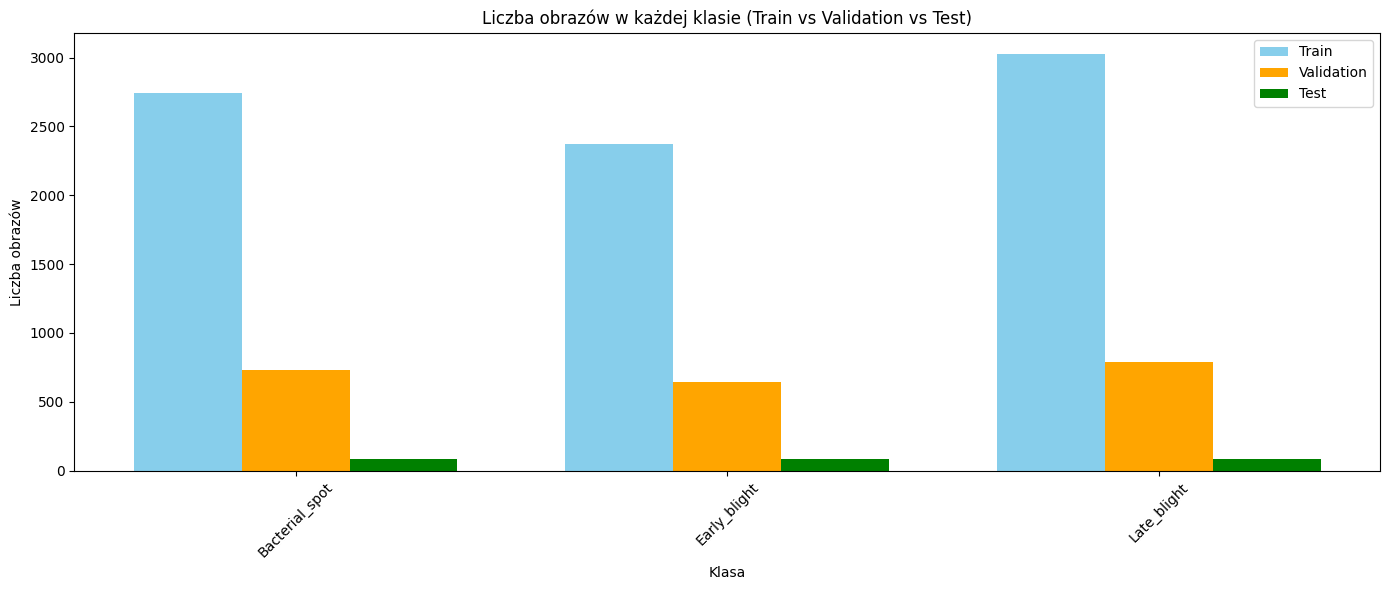

In [37]:
from collections import Counter
import matplotlib.pyplot as plt

# Liczenie próbek
train_counts = Counter(train_gen.classes)
val_counts = Counter(val_gen.classes)
test_counts = Counter(test_gen.classes)  # Dodane liczenie dla test

# Zamiana indeksów klas na nazwy
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
class_names = list(train_gen.class_indices.keys())

# Dane do wykresu
train_vals = [train_counts[i] for i in range(len(class_names))]
val_vals = [val_counts[i] for i in range(len(class_names))]
test_vals = [test_counts[i] for i in range(len(class_names))]  # Dane dla test

# Wykres porównawczy
x = range(len(class_names))
plt.figure(figsize=(14, 6))
bar_width = 0.25

plt.bar([i - bar_width for i in x], train_vals, width=bar_width, label='Train', color='skyblue')
plt.bar(x, val_vals, width=bar_width, label='Validation', color='orange')
plt.bar([i + bar_width for i in x], test_vals, width=bar_width, label='Test', color='green')

plt.xticks(x, class_names, rotation=45)
plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')
plt.title('Liczba obrazów w każdej klasie (Train vs Validation vs Test)')
plt.legend()
plt.tight_layout()
plt.show()


Bacterial_spot, Early_blight, Late_blight


In [40]:
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE
test_steps = test_gen.samples // BATCH_SIZE


In [41]:
def train_model_gen(model, name, train_generator, val_generator, test_generator=None, optimizer=None):
    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam()

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        verbose=1
    )

    # Ewaluacja na walidacji
    val_generator.reset()
    preds = model.predict(val_generator, steps=val_steps + 1)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_generator.classes[:len(y_pred)]

    class_names = list(val_generator.class_indices.keys())
    labels = list(range(len(class_names)))

    print(f"\n{name} Validation Classification Report:\n")
    print(classification_report(y_true, y_pred, labels=labels, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plot_confusion_matrix(cm, class_names, f"{name} Validation Confusion Matrix")
    plot_training_history(history, name)

    # Ewaluacja na teście (jeśli podano test_generator)
    if test_generator is not None:
        import math
        test_steps = math.ceil(test_generator.samples / test_generator.batch_size)
        test_generator.reset()
        preds_test = model.predict(test_generator, steps=test_steps)
        y_pred_test = np.argmax(preds_test, axis=1)
        y_true_test = test_generator.classes[:len(y_pred_test)]

        print(f"\n{name} Test Classification Report:\n")
        print(classification_report(y_true_test, y_pred_test, labels=labels, target_names=class_names, zero_division=0))

        cm_test = confusion_matrix(y_true_test, y_pred_test, labels=labels)
        plot_confusion_matrix(cm_test, class_names, f"{name} Test Confusion Matrix")

    return model


In [ ]:
# 1. CNN from Scratch
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(train_gen.num_classes, activation='softmax')
])
train_model_gen(cnn_model, "CNN From Scratch", train_gen, val_gen)

# Ewaluacja na teście
test_steps = math.ceil(test_gen.samples / BATCH_SIZE)
test_gen.reset()
preds = cnn_model.predict(test_gen, steps=test_steps)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes[:len(y_pred)]
class_names = list(test_gen.class_indices.keys())
labels = list(range(len(class_names)))

print("\nCNN From Scratch Test Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=labels)
plot_confusion_matrix(cm, class_names, "CNN From Scratch Test Confusion Matrix")

c:\Users\Weron\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Weron\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 1012s 993ms/step - accuracy: 0.3971 - loss: 21.2306 - val_accuracy: 0.3676 - val_loss: 1.0851
Epoch 2/5
   1/1017 ━━━━━━━━━━━━━━━━━━━━ 15:42 928ms/step - accuracy: 0.5000 - loss: 1.0760

c:\Users\Weron\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1017/1017 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.5000 - loss: 1.0760 - val_accuracy: 0.3662 - val_loss: 1.0852
Epoch 3/5
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 1005s 988ms/step - accuracy: 0.3920 - loss: 1.0768 - val_accuracy: 0.3778 - val_loss: 1.0826
Epoch 4/5
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.3750 - loss: 1.1340 - val_accuracy: 0.3769 - val_loss: 1.0824
Epoch 5/5
 477/1017 ━━━━━━━━━━━━━━━━━━━━ 8:45 974ms/step - accuracy: 0.3904 - loss: 1.0836

In [ ]:
# 2. MobileNetV2
mobilenet_base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
mobilenet_base.trainable = False

mobilenet_model = tf.keras.Sequential([
    mobilenet_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(train_gen.num_classes, activation='softmax')
])
train_model_gen(mobilenet_model, "MobileNetV2", train_gen, val_gen)

# Ewaluacja na teście
test_gen.reset()
preds = mobilenet_model.predict(test_gen, steps=test_steps)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes[:len(y_pred)]

print("\nMobileNetV2 Test Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=labels)
plot_confusion_matrix(cm, class_names, "MobileNetV2 Test Confusion Matrix")